#### Time Series Analysis

In [11]:
# load some useful libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

In [12]:
df = pd.read_csv('forecasts_and_truth.csv')

In [13]:
display(df.head())

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.0,Observed Data (NYTimes),1630,710.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.0,Observed Data (NYTimes),86,0.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.0,Observed Data (NYTimes),1374,40.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.0,Observed Data (NYTimes),485,151.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.0,Observed Data (NYTimes),8625,883.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475


##### 1. Try time-series for California

In [14]:
california_df = df[df['target_variable'] == 'inc case']
california_df = california_df.drop_duplicates(subset=['target_end_date', 'location_name'], keep='first')

california_df = california_df[['target_end_date', 'location_name', 'truth_value']]
california_df.columns = ['date', 'location_key', 'inc_case']

california_df = california_df[california_df['location_key'] == 'California']

display(california_df)

,date,location_key,inc_case
4,2020-04-11,California,8625
64,2020-04-18,California,8408
180,2020-04-25,California,11761
352,2020-05-02,California,11163
576,2020-05-09,California,13071
...,...,...,...
608731,2022-04-09,California,23817
613407,2022-04-16,California,26421
618049,2022-04-23,California,34792
622718,2022-04-30,California,43902


##### 2. Plot time series of the cases

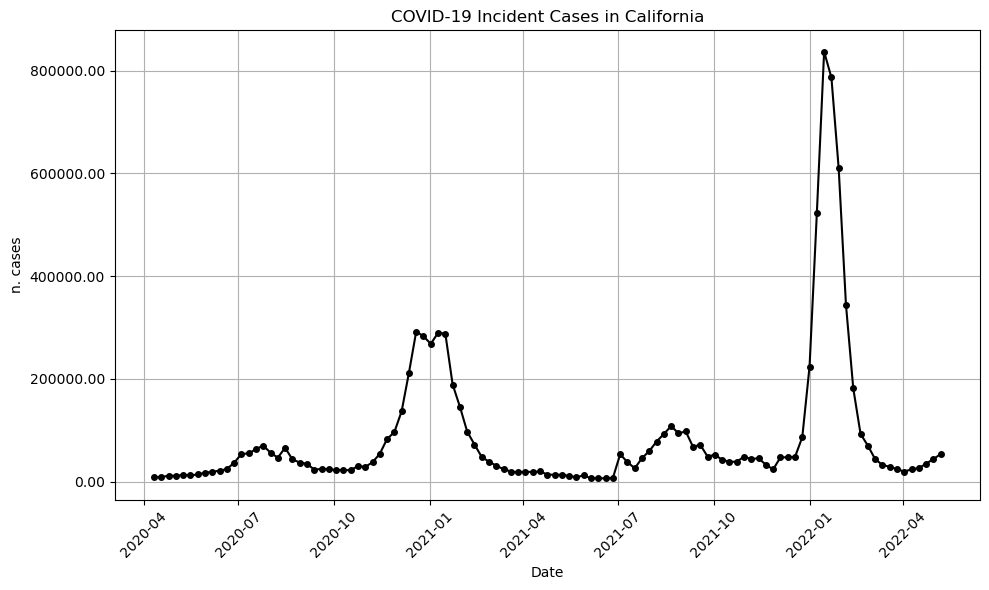

In [15]:
california_df['date'] = pd.to_datetime(california_df['date'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(california_df['date'], california_df['inc_case'], marker='o', linestyle='-', color='black',markersize = '4')
plt.title('COVID-19 Incident Cases in California')
plt.xlabel('Date')
plt.ylabel('n. cases')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 3. Use the ADF function test whether the series is stationary. Remember your null-hypothesis is that there is a unit-root (i.e. it's a random walk or a random walk with drift), and hence a non-stationary process. A p-value close to zero here tells us the process is stationary. 

In [16]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(california_df['inc_case'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -3.573423
p-value                          0.006290
#Lags Used                       2.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64

##### 4. Stabilise the series' variance via a monotonic transformation. 

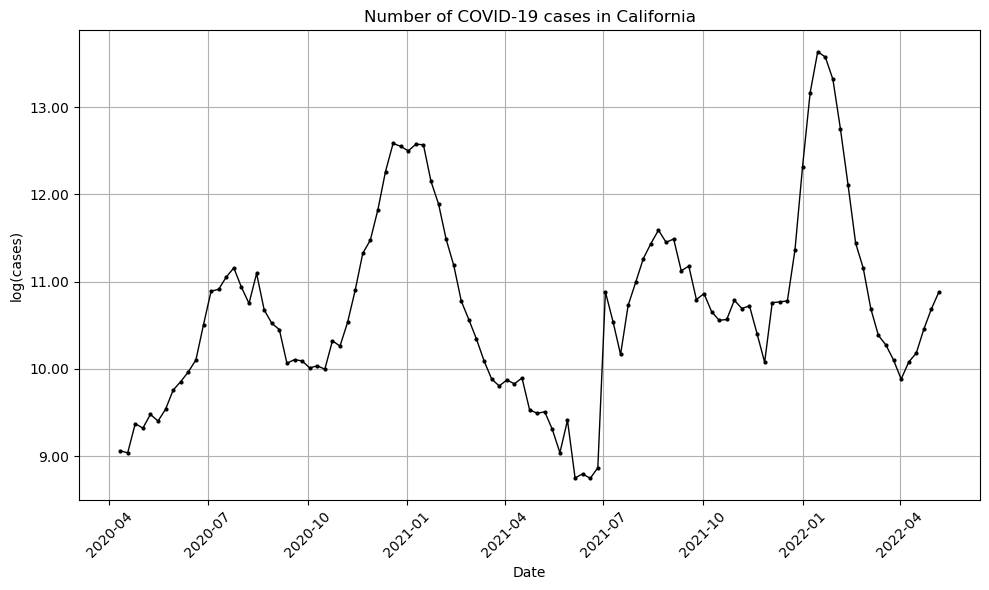

In [18]:
# You can take the log of the series. 
california_df['log_inc_case'] = np.log(california_df['inc_case'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(california_df['date'], california_df['log_inc_case'], marker='o', linestyle='-', color='black',markersize = 2,linewidth=1)
plt.title('Number of COVID-19 cases in California')
plt.xlabel('Date')
plt.ylabel('log(cases)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 5. Check if the series is stationary

In [19]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(california_df['log_inc_case'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -3.895966
p-value                          0.002065
#Lags Used                       3.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64

##### 6. Calculate and plot the first difference of the number of cases.

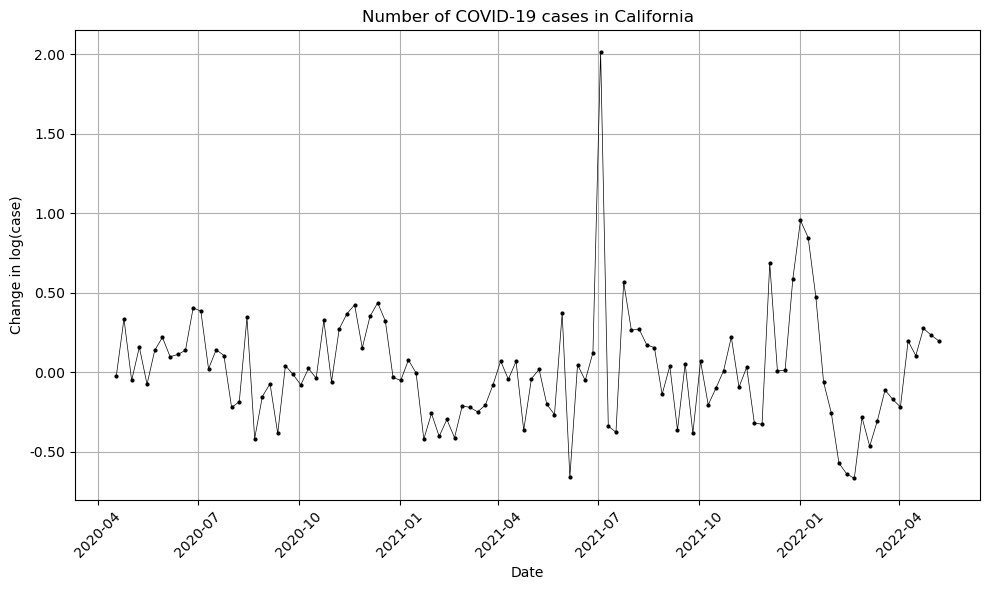

In [20]:
# Calculate the first difference 
california_df['log_inc_case_diff'] = california_df['log_inc_case'].diff()

# Plotting the first difference of the log-transformed series
plt.figure(figsize=(10, 6))
plt.plot(california_df['date'], california_df['log_inc_case_diff'], marker='o', linestyle='-', color='black', markersize=2,linewidth=0.5)
plt.title('Number of COVID-19 cases in California')
plt.xlabel('Date')
plt.ylabel('Change in log(case)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 6. Check if the series is stationary

In [21]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(california_df['log_inc_case_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -3.746051
p-value                          0.003510
#Lags Used                       2.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64

##### 7. Using the ACF and PACF, identify the SARIMA order of this series. 

<Figure size 1200x600 with 0 Axes>

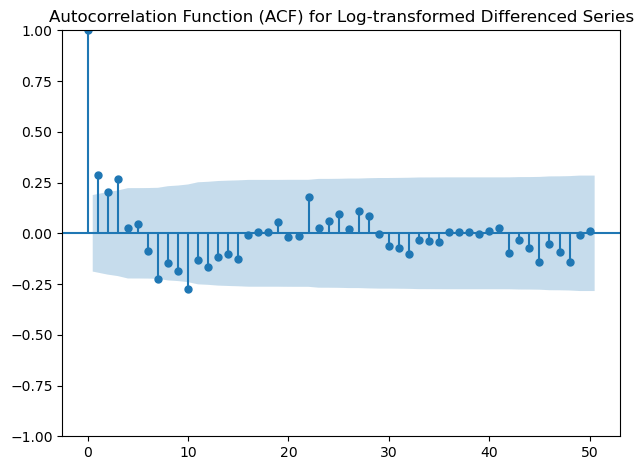

<Figure size 1200x600 with 0 Axes>

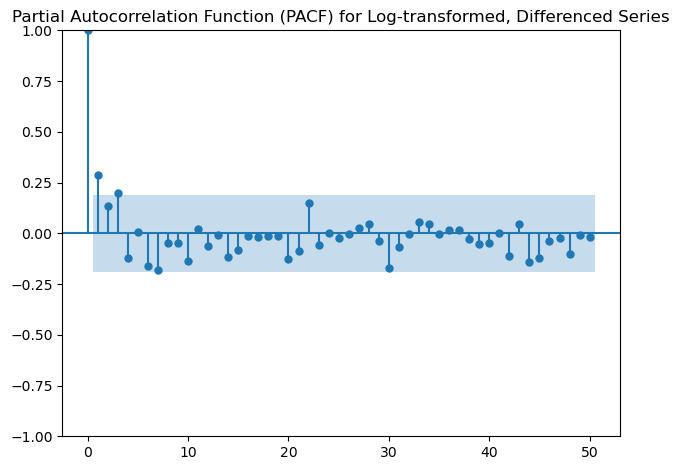

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(california_df['log_inc_case_diff'].dropna(), lags=50, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(california_df['log_inc_case_diff'].dropna(), lags=50, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

In [25]:
import pandas as pd
from pmdarima import auto_arima

# Assuming series contains your time series data and 'date' column is already in datetime format
series = california_df['inc_case'].dropna()

# Set the index of the series to the 'date' column
series.index = pd.to_datetime(california_df['date'])

# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,
                        m=48,
                        seasonal=False,
                        test='adf',
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2927.531, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2709.010, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2840.715, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2631.625, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2616.916, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=2618.290, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2618.571, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2622.618, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2617.996, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2614.213, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2624.017, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2616.091, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2616.211, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2618.285, Time=0.01 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept

##### 8. Using a 'Rolling Origin' type forecast, estimate the expected one-step-ahead generalisation error.

In [26]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (3, 0, 0)
Seasonal order: (0, 0, 0, 0)


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import trange

# Split the dataset into training and test sets
train_size = int(len(series) * 0.75)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in trange(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

100%|██████████| 28/28 [00:00<00:00, 81.48it/s]


Test RMSE: 87243.570958556


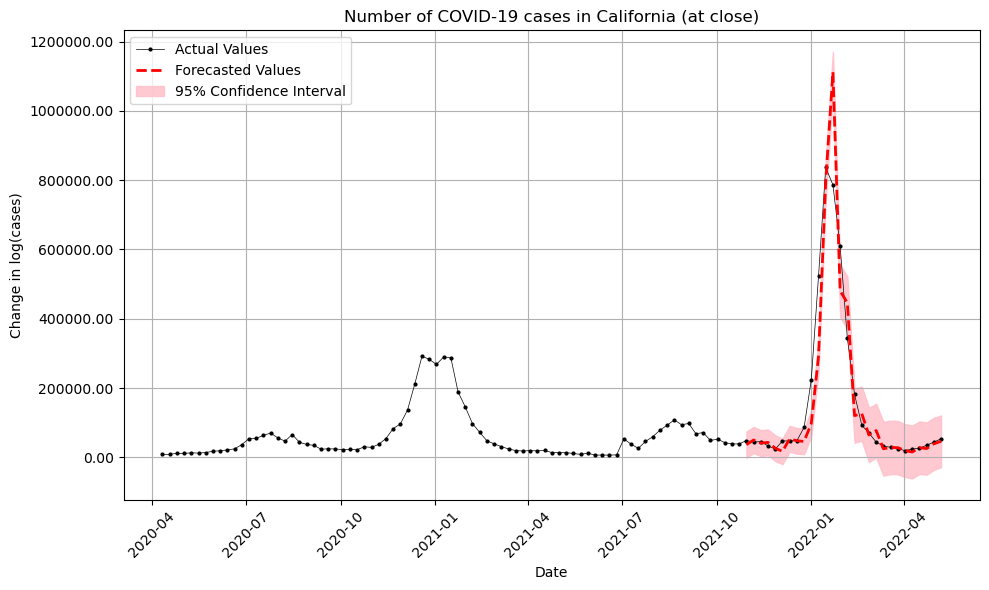

In [28]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Number of COVID-19 cases in California (at close)')
plt.xlabel('Date')
plt.ylabel('Change in log(cases)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()